In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./data/hand_gestures/reload.csv
./data/hand_gestures/bomb.csv
./data/hand_gestures/raise_arm.csv
./data/hand_gestures/gesture_data.csv
./data/hand_gestures/basket.csv
./data/hand_gestures/shaking.csv
./data/hand_gestures/shield.csv
./data/hand_gestures/stationary.csv
./data/hand_gestures/bowl.csv
./data/hand_gestures/volley.csv
./data/hand_gestures/logout.csv
./data/leg_gestures/soccer.csv
./data/leg_gestures/run.csv
./data/leg_gestures/walk.csv
./data/leg_gestures/stationary_leg.csv


In [6]:
import pandas as pd
import ast

# Define the function to convert string representation of list to actual list
def str_to_list(s):
    return [float(x.strip()) for x in s.strip('[]').split(',')]

# Custom converters for array columns
array_converters = {'ax': str_to_list, 'ay': str_to_list, 'az': str_to_list,
                    'gx': str_to_list, 'gy': str_to_list, 'gz': str_to_list}

EXPECTED_SIZE = 60

# Initialize an empty list to store the training data
all_data = []

# Define the gestures and corresponding CSV files
# gestures = ['basket', 'bomb', 'bowl', 'logout', 'reload', 'shield', 'volley']
gestures = ['basket', 'bomb', 'bowl', 'logout', 'reload', 'shield', 'volley', 'stationary', 'shaking', 'raise_arm']
# gestures = ['stationary_leg', 'soccer', 'run', 'walk']
directory = './data/hand_gestures/'
csv_files = [f'{directory}{gesture}.csv' for gesture in gestures]

# Define the column names
column_names = ['ax', 'ay', 'az', 'gx', 'gy', 'gz']

# Loop through each gesture and load the corresponding CSV file
for gesture, csv_file in zip(gestures, csv_files):
    # Read the CSV file without headers and assign the column names
    print(f"Loading data for {gesture} gesture from {csv_file}")
    gesture_data = pd.read_csv(csv_file, header=None, names=column_names, converters=array_converters)
    
    # Add a column for the label
    gesture_data['label'] = gesture
    
    # Append to the list of all data
    all_data.append(gesture_data)

# Combine all the data into one DataFrame
training_data = pd.concat(all_data, ignore_index=True)

# Verify the changes
print("Training data 'ax' column first row:")
print(training_data.loc[0, 'ax'])
print("\nType of 'ax' column first row:")
print(type(training_data.loc[0, 'ax']))

# Display the first few rows of the training data to ensure it is loaded correctly
print(training_data.head())

# how many samples do we have for each gesture?
training_data['label'].value_counts()


Loading data for basket gesture from ./data/hand_gestures/basket.csv
Loading data for bomb gesture from ./data/hand_gestures/bomb.csv
Loading data for bowl gesture from ./data/hand_gestures/bowl.csv
Loading data for logout gesture from ./data/hand_gestures/logout.csv
Loading data for reload gesture from ./data/hand_gestures/reload.csv
Loading data for shield gesture from ./data/hand_gestures/shield.csv
Loading data for volley gesture from ./data/hand_gestures/volley.csv
Loading data for stationary gesture from ./data/hand_gestures/stationary.csv
Loading data for shaking gesture from ./data/hand_gestures/shaking.csv
Loading data for raise_arm gesture from ./data/hand_gestures/raise_arm.csv
Training data 'ax' column first row:
[-6649.0, -5811.0, -12934.0, -20451.0, -5332.0, -28241.0, -32768.0, -32768.0, -32768.0, -19983.0, -391.0, -2831.0, -12240.0, -24682.0, -27711.0, -32768.0, -32768.0, -29834.0, -24847.0, -23192.0, -18870.0, -16738.0, -16938.0, -15829.0, -13473.0, -8347.0, -3242.0, 18

label
reload        404
basket        400
bomb          400
bowl          400
logout        400
shield        400
volley        400
stationary     50
shaking        50
raise_arm      50
Name: count, dtype: int64

In [7]:
# checking how many data points per axes
mydict = {'ax': [9999,0],
          'ay': [9999,0],
          'az': [9999,0],
          'gx': [9999,0],
          'gy': [9999,0],
          'gz': [9999,0]}
for i in range(len(training_data)):
    for axes, hidden in mydict.items():
        # if less than 60, print which row
        if len(training_data.loc[i, axes]) < EXPECTED_SIZE:
            print(f"Row {i} has less than {EXPECTED_SIZE} data points for {axes}")
        
        if len(training_data.loc[i, axes]) < hidden[0]:
            mydict[axes][0] = len(training_data.loc[i, axes])
        if len(training_data.loc[i, axes]) > hidden[1]:
            mydict[axes][1] = len(training_data.loc[i, axes])

print(mydict)

{'ax': [60, 60], 'ay': [60, 60], 'az': [60, 60], 'gx': [60, 60], 'gy': [60, 60], 'gz': [60, 60]}


In [4]:
print(training_data.head())

                                                  ax  \
0  [-6649.0, -5811.0, -12934.0, -20451.0, -5332.0...   
1  [-17559.0, -28770.0, 1319.0, -18755.0, -29410....   
2  [-15581.0, -26406.0, -22033.0, -3871.0, -14629...   
3  [-32768.0, -32768.0, -32768.0, -18784.0, -9929...   
4  [-24947.0, -19761.0, -18580.0, -20769.0, -2555...   

                                                  ay  \
0  [-8667.0, -12646.0, -15068.0, -12672.0, -9945....   
1  [-8533.0, -22590.0, -9835.0, -18041.0, -13300....   
2  [-2475.0, -3119.0, -2052.0, -4385.0, -6981.0, ...   
3  [-1474.0, -12502.0, -4669.0, -5991.0, -2357.0,...   
4  [-3093.0, 4173.0, 5089.0, 5894.0, 4035.0, 1947...   

                                                  az  \
0  [-8884.0, -20617.0, -25916.0, -30000.0, -32768...   
1  [-12485.0, -32768.0, -32768.0, -24646.0, -1919...   
2  [-7367.0, -9303.0, -14051.0, -21661.0, -16647....   
3  [-17729.0, -1967.0, -2149.0, -2927.0, -1593.0,...   
4  [-518.0, 1733.0, 1579.0, 10627.0, 11024.0, 

In [8]:
from sklearn.model_selection import train_test_split

# Function to pad or truncate the array
def pad_or_truncate(array, target_length=EXPECTED_SIZE):
    if len(array) > target_length:
        return array[:target_length]
    elif len(array) < target_length:
        return array + [0] * (target_length - len(array))
    else:
        return array

# Apply padding or truncating to each column in the training data
for col in ["ax", "ay", "az", "gx", "gy", "gz"]:
    training_data[col] = training_data[col].apply(pad_or_truncate)

# Get the labels
labels = training_data['label']

# Splitting the data into 40% Train, 30% Test, and 30% Hidden
train_data, temp_data = train_test_split(training_data, test_size=0.6, stratify=labels, random_state=42)

temp_labels = temp_data['label']
test_data, hidden_data = train_test_split(temp_data, test_size=0.5, stratify=temp_labels, random_state=42)

# Print how many samples in each set
print("Train data samples:", len(train_data))
print("Test data samples:", len(test_data))
print("Hidden data samples:", len(hidden_data))

# Verify that each set has balanced labels
print("Train label distribution:\n", train_data['label'].value_counts())
print("Test label distribution:\n", test_data['label'].value_counts())
print("Hidden label distribution:\n", hidden_data['label'].value_counts())

Train data samples: 1181
Test data samples: 886
Hidden data samples: 887
Train label distribution:
 label
reload        161
bowl          160
basket        160
bomb          160
logout        160
shield        160
volley        160
shaking        20
stationary     20
raise_arm      20
Name: count, dtype: int64
Test label distribution:
 label
reload        121
logout        120
basket        120
volley        120
shield        120
bomb          120
bowl          120
raise_arm      15
stationary     15
shaking        15
Name: count, dtype: int64
Hidden label distribution:
 label
reload        122
bomb          120
bowl          120
logout        120
volley        120
basket        120
shield        120
shaking        15
stationary     15
raise_arm      15
Name: count, dtype: int64


In [9]:
import pandas as pd
import numpy as np
import random
from scipy.interpolate import CubicSpline

# Function for data augmentation using CubicSpline
def time_warping(time_series, num_operations, warp_factor):
    warped_series = time_series.copy()
    
    num_insertions = num_operations // 2
    num_deletions = num_insertions
    
    for _ in range(num_insertions):
        index = random.randint(1, len(warped_series) - 2)
        insertion_value = (warped_series[index - 1] + warped_series[index]) * 0.5
        warp_amount = insertion_value * warp_factor * random.uniform(-1, 1)
        warped_series = np.insert(warped_series, index, insertion_value + warp_amount)
    
    for _ in range(num_deletions):
        if len(warped_series) > 2:
            index = random.randint(1, len(warped_series) - 2)
            warped_series = np.delete(warped_series, index)
    
    return warped_series[:EXPECTED_SIZE]  # Ensure the length is EXPECTED_SIZE

def magnitude_warping(time_series, num_knots, warp_std_dev):
    knot_positions = np.linspace(0, len(time_series) - 1, num=num_knots)
    knot_values = 1 + np.random.normal(0, warp_std_dev, num_knots)

    spline = CubicSpline(knot_positions, knot_values)
    time_indexes = np.arange(len(time_series))

    warped_time_series = time_series * spline(time_indexes)
    return warped_time_series[:EXPECTED_SIZE]  # Ensure the length is EXPECTED_SIZE

def augment_data(ax, ay, az, gx, gy, gz, num_augmented=1, time_warp_factor=0.05, mag_warp_std_dev=0.05):
    original_length = len(ax)
    
    midpoint_factor = 0.5
    deviation_factor = 0.1
    midpoint = int(original_length * midpoint_factor)
    min_hidden = int(midpoint * (1 - deviation_factor))
    max_hidden = int(midpoint * (1 + deviation_factor))

    num_operations = random.randint(min_hidden, max_hidden)
    mag_warp_knots = random.randint(min_hidden, max_hidden)
    
    augmented_data = []
    for _ in range(num_augmented):
        warped_ax = time_warping(ax, num_operations=num_operations, warp_factor=time_warp_factor)
        warped_ay = time_warping(ay, num_operations=num_operations, warp_factor=time_warp_factor)
        warped_az = time_warping(az, num_operations=num_operations, warp_factor=time_warp_factor)
        warped_gx = time_warping(gx, num_operations=num_operations, warp_factor=time_warp_factor)
        warped_gy = time_warping(gy, num_operations=num_operations, warp_factor=time_warp_factor)
        warped_gz = time_warping(gz, num_operations=num_operations, warp_factor=time_warp_factor)

        warped_ax = magnitude_warping(warped_ax, num_knots=mag_warp_knots, warp_std_dev=mag_warp_std_dev)
        warped_ay = magnitude_warping(warped_ay, num_knots=mag_warp_knots, warp_std_dev=mag_warp_std_dev)
        warped_az = magnitude_warping(warped_az, num_knots=mag_warp_knots, warp_std_dev=mag_warp_std_dev)
        warped_gx = magnitude_warping(warped_gx, num_knots=mag_warp_knots, warp_std_dev=mag_warp_std_dev)
        warped_gy = magnitude_warping(warped_gy, num_knots=mag_warp_knots, warp_std_dev=mag_warp_std_dev)
        warped_gz = magnitude_warping(warped_gz, num_knots=mag_warp_knots, warp_std_dev=mag_warp_std_dev)

        augmented_data.append({
            'ax': warped_ax.tolist(),
            'ay': warped_ay.tolist(),
            'az': warped_az.tolist(),
            'gx': warped_gx.tolist(),
            'gy': warped_gy.tolist(),
            'gz': warped_gz.tolist()
        })
    
    return augmented_data

# Example of loading and augmenting the data
augmented_data = []
for _, row in train_data.iterrows():
    augmented = augment_data(
        np.array(row['ax']), np.array(row['ay']), np.array(row['az']),
        np.array(row['gx']), np.array(row['gy']), np.array(row['gz']),
        num_augmented=0
    )
    for aug in augmented:
        new_row = row.copy()
        new_row['ax'] = aug['ax']
        new_row['ay'] = aug['ay']
        new_row['az'] = aug['az']
        new_row['gx'] = aug['gx']
        new_row['gy'] = aug['gy']
        new_row['gz'] = aug['gz']
        augmented_data.append(new_row)

# Combine original and augmented data
augmented_train_data = pd.concat([train_data, pd.DataFrame(augmented_data)], ignore_index=True)

# Verify the new data structure
print(augmented_train_data.head())

# print how many samples in each set
print("Original data samples:", len(train_data))
print("Augmented data samples:", len(augmented_train_data))


                                                  ax  \
0  [-13268.0, -15971.0, -13463.0, -19494.0, -3276...   
1  [-12215.0, -16886.0, -22145.0, -28787.0, -3276...   
2  [-17503.0, -19480.0, -10297.0, -6743.0, -1974....   
3  [-6326.0, -13126.0, -19199.0, -24576.0, -28027...   
4  [-11033.0, -17843.0, -23720.0, -30866.0, -3276...   

                                                  ay  \
0  [-7320.0, -7674.0, -11249.0, -13507.0, -18533....   
1  [443.0, 1643.0, 2522.0, 2715.0, 2206.0, 2143.0...   
2  [3960.0, -648.0, -2473.0, -1413.0, -1698.0, -1...   
3  [-12108.0, -14566.0, -11715.0, -5697.0, -1242....   
4  [-8832.0, -11923.0, -9757.0, -3047.0, -2342.0,...   

                                                  az  \
0  [-12567.0, -32134.0, -28693.0, -24162.0, -1820...   
1  [98.0, -2115.0, -4193.0, -5228.0, -6025.0, -65...   
2  [19887.0, 13321.0, 1889.0, 5068.0, 7506.0, 522...   
3  [11952.0, 25270.0, 32767.0, 24906.0, 16596.0, ...   
4  [9897.0, 8106.0, 3530.0, -2803.0, -13356.0,

In [10]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Fit the MinMaxScaler to 16-bit signed integer range
scaler = MinMaxScaler(feature_range=(-1, 1))  # Scale data between -1 and 1
scaler.fit(np.array([-2**15, 2**15 - 1]).reshape(-1, 1))

# Function to scale individual arrays using the fitted MinMaxScaler
def scale_array(arr):
    arr = np.array(arr).reshape(-1, 1)  # Reshape for scaler
    return scaler.transform(arr).flatten().tolist()  # Flatten back to 1D list

# Apply the scaling function to each column (ax, ay, az, gx, gy, gz) in the training, test, and hidden datasets
for col in ["ax", "ay", "az", "gx", "gy", "gz"]:
    # Scale augmented training data
    augmented_train_data[col] = augmented_train_data[col].apply(scale_array)
    
    # Scale test data
    test_data[col] = test_data[col].apply(scale_array)
    
    # Scale hidden data
    hidden_data[col] = hidden_data[col].apply(scale_array)

# Now `augmented_train_data`, `test_data`, and `hidden_data` are scaled consistently using the MinMaxScaler

# print a few samples of scaled data
print("Scaled augmented training data samples:")
print(augmented_train_data.head())
print("\nScaled test data samples:")
print(test_data.head())
print("\nScaled hidden data samples:")
print(hidden_data.head())

Scaled augmented training data samples:
                                                  ax  \
0  [-0.40489814602883956, -0.4873884184023804, -0...   
1  [-0.3727626459143969, -0.5153124284733348, -0....   
2  [-0.5341420614938582, -0.5944762340733959, -0....   
3  [-0.19304188601510644, -0.4005645838101778, -0...   
4  [-0.33669031815060657, -0.5445181963836118, -0...   

                                                  ay  \
0  [-0.22337682154573893, -0.23418020904859999, -...   
1  [0.013534752422369727, 0.05015640497444114, 0....   
2  [0.12086671244373236, -0.019760433356221865, -...   
3  [-0.3694972152285039, -0.44451056687266344, -0...   
4  [-0.2695201037613489, -0.36385137712672616, -0...   

                                                  az  \
0  [-0.3835049973296712, -0.9806515602349889, -0....   
1  [0.003006027313649195, -0.06453040360112917, -...   
2  [0.6069275959411001, 0.40654612039368276, 0.05...   
3  [0.36476691844052794, 0.7712062256809339, 1.0,...   
4  [0.

In [11]:
# Check for min and max lengths in the data
min_max_lengths = {'ax': [9999, 0], 'ay': [9999, 0], 'az': [9999, 0], 'gx': [9999, 0], 'gy': [9999, 0], 'gz': [9999, 0]}
for i in range(len(augmented_train_data)):
    for axes, hidden in min_max_lengths.items():
        if len(augmented_train_data.loc[i, axes]) < hidden[0]:
            min_max_lengths[axes][0] = len(augmented_train_data.loc[i, axes])
        if len(augmented_train_data.loc[i, axes]) > hidden[1]:
            min_max_lengths[axes][1] = len(augmented_train_data.loc[i, axes])

print(min_max_lengths)

# Find final min and max hiddenues
min_hiddenues = {}
max_hiddenues = {}

for column in ["ax","ay","az","gx","gy","gz"]:
    min_hiddenues[column] = np.min([np.min(row) for row in augmented_train_data[column] if isinstance(row, list)])
    max_hiddenues[column] = np.max([np.max(row) for row in augmented_train_data[column] if isinstance(row, list)])

for column in ["ax","ay","az","gx","gy","gz"]:
    print(f"{column} - Min: {min_hiddenues[column]}, Max: {max_hiddenues[column]}")
    
# verify the changes by getting the shape of the data
print(augmented_train_data.shape)
print(test_data.shape)
print(hidden_data.shape)


{'ax': [60, 60], 'ay': [60, 60], 'az': [60, 60], 'gx': [60, 60], 'gy': [60, 60], 'gz': [60, 60]}
ax - Min: -1.0, Max: 1.0
ay - Min: -1.0, Max: 1.0
az - Min: -1.0, Max: 1.0
gx - Min: -1.0, Max: 1.0
gy - Min: -1.0, Max: 1.0
gz - Min: -1.0, Max: 1.0
(1181, 7)
(886, 7)
(887, 7)


In [12]:
# print head for augmented data
# print(augmented_train_data.head())
# print(test_data.head())
# print(hidden_data.head())

# print proportion of each gesture in the augmented data
print(augmented_train_data['label'].value_counts(normalize=True))

label
reload        0.136325
bowl          0.135478
basket        0.135478
bomb          0.135478
logout        0.135478
shield        0.135478
volley        0.135478
shaking       0.016935
stationary    0.016935
raise_arm     0.016935
Name: proportion, dtype: float64


In [13]:
import numpy as np

# Convert NumPy arrays to lists of floats for all the relevant columns
augmented_train_data['ax'] = augmented_train_data['ax'].apply(lambda x: list(map(float, x)))
augmented_train_data['ay'] = augmented_train_data['ay'].apply(lambda y: list(map(float, y)))
augmented_train_data['az'] = augmented_train_data['az'].apply(lambda z: list(map(float, z)))
augmented_train_data['gx'] = augmented_train_data['gx'].apply(lambda x: list(map(float, x)))
augmented_train_data['gy'] = augmented_train_data['gy'].apply(lambda y: list(map(float, y)))
augmented_train_data['gz'] = augmented_train_data['gz'].apply(lambda z: list(map(float, z)))

test_data['ax'] = test_data['ax'].apply(lambda x: list(map(float, x)))
test_data['ay'] = test_data['ay'].apply(lambda y: list(map(float, y)))
test_data['az'] = test_data['az'].apply(lambda z: list(map(float, z)))
test_data['gx'] = test_data['gx'].apply(lambda x: list(map(float, x)))
test_data['gy'] = test_data['gy'].apply(lambda y: list(map(float, y)))
test_data['gz'] = test_data['gz'].apply(lambda z: list(map(float, z)))

hidden_data['ax'] = hidden_data['ax'].apply(lambda x: list(map(float, x)))
hidden_data['ay'] = hidden_data['ay'].apply(lambda y: list(map(float, y)))
hidden_data['az'] = hidden_data['az'].apply(lambda z: list(map(float, z)))
hidden_data['gx'] = hidden_data['gx'].apply(lambda x: list(map(float, x)))
hidden_data['gy'] = hidden_data['gy'].apply(lambda y: list(map(float, y)))
hidden_data['gz'] = hidden_data['gz'].apply(lambda z: list(map(float, z)))

augmented_train_data.to_csv("./processed/processed_train_gesture_data.csv", index=False)
test_data.to_csv("./processed/processed_test_gesture_data.csv", index=False)
hidden_data.to_csv("./processed/processed_hidden_gesture_data.csv", index=False)


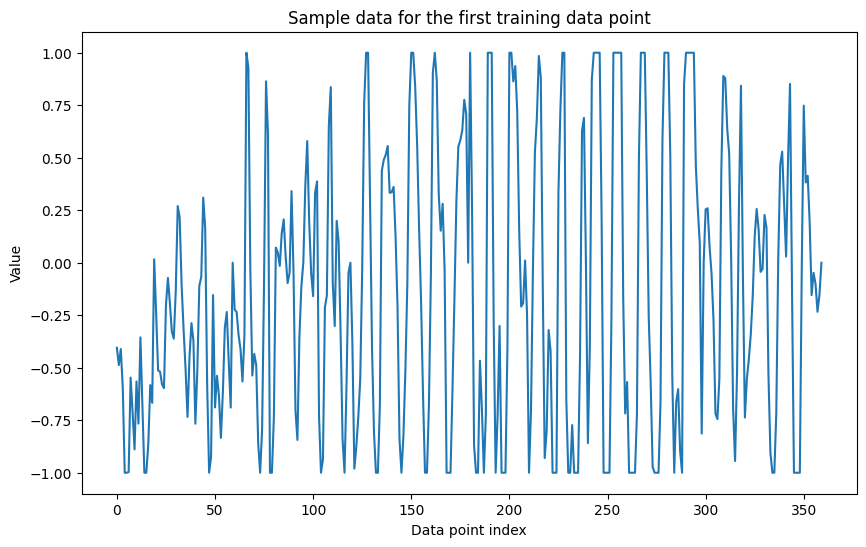

X_train shape: (1181, 360, 1)
X_test shape: (886, 360, 1)
y_train shape: (1181, 10)
y_test shape: (886, 10)


/home/prince/Documents/capstone/Gesture-AI/.venv/lib/python3.12/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 360, 32)        │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 360, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,978 (124.91 KB)

 Trainable params: 31,786 (124.16 KB)

 Non-trainable params: 192 (768.00 B)

In [16]:
# load in for single training

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import setuptools.dist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import InputLayer, Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
import pickle


# Load the processed train and test data
train_data = pd.read_csv("./processed/processed_train_gesture_data.csv")
test_data = pd.read_csv("./processed/processed_test_gesture_data.csv")
hidden_data = pd.read_csv("./processed/processed_hidden_gesture_data.csv")

def str_to_list(s):
    return [float(x.strip()) for x in s.strip('[]').split(',')]

# Concatenating 6 columns: ax, ay, az, gx, gy, gz
X_train = np.array([str_to_list(row['ax']) + str_to_list(row['ay']) + str_to_list(row['az']) +
                    str_to_list(row['gx']) + str_to_list(row['gy']) + str_to_list(row['gz'])
                    for _, row in train_data.iterrows()], dtype=np.float32)

X_test = np.array([str_to_list(row['ax']) + str_to_list(row['ay']) + str_to_list(row['az']) +
                   str_to_list(row['gx']) + str_to_list(row['gy']) + str_to_list(row['gz'])
                   for _, row in test_data.iterrows()], dtype=np.float32)

X_hidden = np.array([str_to_list(row['ax']) + str_to_list(row['ay']) + str_to_list(row['az']) +
                     str_to_list(row['gx']) + str_to_list(row['gy']) + str_to_list(row['gz'])
                     for _, row in hidden_data.iterrows()], dtype=np.float32)


# plot some data to sanity check    
import matplotlib.pyplot as plt

# Plot the first sample in the training data
plt.figure(figsize=(10, 6))
plt.plot(X_train[0])
plt.title("Sample data for the first training data point")
plt.xlabel("Data point index")
plt.ylabel("Value")
plt.show()



# Prepare the labels for training
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['label'])
y_test = label_encoder.transform(test_data['label'])
y_hidden = label_encoder.transform(hidden_data['label'])

# Save the LabelEncoder to a file for later use
with open('./model_dir/label_encoder.pkl', 'wb') as file:
    pickle.dump(label_encoder, file)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_hidden = to_categorical(y_hidden)

# Reshape input data to match the input shape expected by the 1D CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_hidden = X_hidden.reshape(X_hidden.shape[0], X_hidden.shape[1], 1)

# Automate input shape
sequence_length = X_train.shape[1]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# RNN model test
# Define the RNN model
model = Sequential([
    InputLayer(input_shape=(sequence_length, 1)),  # 6 features for the axes

    # LSTM layer 1
    LSTM(32, return_sequences=True, activation='relu'),
    BatchNormalization(),
    
    # LSTM layer 2
    LSTM(64, return_sequences=False, activation='relu'),
    BatchNormalization(),

    # Dense layers
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),
    Dense(y_train.shape[1], activation='softmax')  # Output layer
])

# hand model 50 data points
# model = Sequential([
#     InputLayer(input_shape=(sequence_length, 1)),
    
#     # Conv1D layer 1
#     Conv1D(filters=16, kernel_size=5, activation='relu'),  # Filters: 16, Kernel size: 5
#     BatchNormalization(),  # Batch Normalization with 4 weights
#     MaxPooling1D(pool_size=3),  # MaxPooling1D with pool size 3
    
#     # Conv1D layer 2
#     Conv1D(filters=12, kernel_size=3, activation='relu'),  # Filters: 12, Kernel size: 3
#     BatchNormalization(),  # Batch Normalization with 4 weights
#     MaxPooling1D(pool_size=4),  # MaxPooling1D with pool size 4
    
#     # Flatten and Dense layers
#     Flatten(),
#     Dense(16, activation='relu'),  # Fully connected layer with 16 units
#     Dense(12, activation='relu'),  # Fully connected layer with 12 units
#     BatchNormalization(),  # Batch Normalization with 4 weights
#     Dense(10, activation='softmax')  # Output layer with 10 units
# ])

# hand model old 60 data points
# model = Sequential([
#     InputLayer(input_shape=(sequence_length, 1)),
    
#     # Conv1D layer 1
#     Conv1D(filters=4, kernel_size=5, activation='relu'),
#     BatchNormalization(),
#     MaxPooling1D(pool_size=3),
    
#     # Conv1D layer 2
#     Conv1D(filters=16, kernel_size=3, activation='relu'),
#     BatchNormalization(),
#     MaxPooling1D(pool_size=4),
    
#     # Conv1D layer 3
#     Conv1D(filters=16, kernel_size=5, activation='relu'),
#     BatchNormalization(),
#     MaxPooling1D(pool_size=2),
    
#     # Flatten and Dense layers
#     Flatten(),
#     Dense(12, activation='relu', kernel_regularizer=l2(0.01)),
#     Dense(y_train.shape[1], activation='softmax')
# ])

# leg model
# model = Sequential([
#     # Input Layer
#     InputLayer(input_shape=(240, 1)),  # Assuming input shape of 240 timesteps with 1 feature each
    
#     # Conv1D layer 1 ({MODEL_TYPE}_conv1d_3 from your table)
#     Conv1D(filters=16, kernel_size=3, activation='relu'),  # 16 filters, kernel size 3
#     # No Pooling/Normalization mentioned in your example

#     # Flatten layer ({MODEL_TYPE}_flatten_1)
#     Flatten(),  # Flattens the (None, 238, 16) into (None, 3808)

#     # Dense layer 1 ({MODEL_TYPE}_dense_2)
#     Dense(8, activation='relu'),  # (None, 3808) to (None, 8)

#     # Dense layer 2 ({MODEL_TYPE}_dense_3)
#     Dense(4, activation='softmax')  # (None, 8) to (None, 4) for classification
# ])

# model = Sequential([
#     InputLayer(input_shape=(sequence_length,)),
#     Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
#     Dense(64, activation='relu', kernel_regularizer=l2(0.01)),
#     Dense(y_train.shape[1], activation='softmax')
# ])

# Summary
model.summary()


In [17]:
# load in for single training


# Compile the model
from tensorflow.keras.optimizers import Adam

# Create the Adam optimizer with a custom learning rate
adam_optimizer = Adam(learning_rate=0.001)  

model.compile(optimizer=adam_optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

from tensorflow.keras.callbacks import EarlyStopping

# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')

print("Training model...")

# Train the model with early stopping
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=50, batch_size=32, verbose=1, callbacks=[early_stopping])


Training model...
Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 26s 452ms/step - accuracy: 0.1877 - loss: 2.7605 - val_accuracy: 0.1456 - val_loss: 2.6675
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 17s 460ms/step - accuracy: 0.3346 - loss: 2.3758 - val_accuracy: 0.1569 - val_loss: 2.6044
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 21s 570ms/step - accuracy: 0.3627 - loss: 2.1838 - val_accuracy: 0.1682 - val_loss: 2.5472
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 418ms/step - accuracy: 0.4096 - loss: 2.0707 - val_accuracy: 0.1761 - val_loss: 2.4998
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 415ms/step - accuracy: 0.4463 - loss: 1.9712 - val_accuracy: 0.1546 - val_loss: 2.4624
Epoch 6/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 418ms/step - accuracy: 0.4598 - loss: 1.8953 - val_accuracy: 0.1445 - val_loss: 2.4323
Epoch 7/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 15s 412ms/step - accuracy: 0.4671 - loss: 1.8556 - val_accuracy: 0.1479 - val_loss: 2.4085
Epoch 8/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 16s 421ms/step - accuracy: 0.4595 - loss:

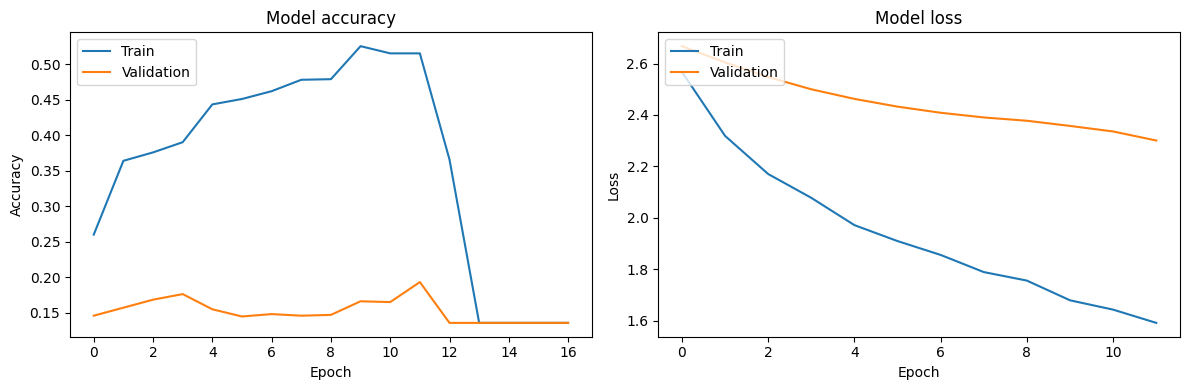

28/28 ━━━━━━━━━━━━━━━━━━━━ 5s 159ms/step


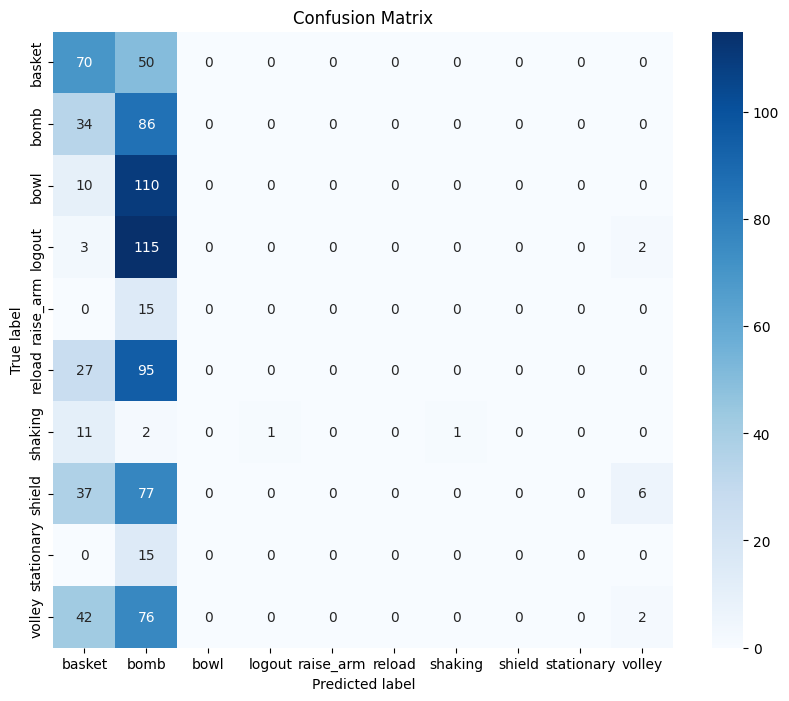

Hidden accuracy: 0.1793


In [18]:
# load in for single training
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming label_encoder is already loaded and trained
# Use the label_encoder to convert numeric labels back to their original string labels

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

# Confusion Matrix
y_pred = model.predict(X_hidden)
y_pred_classes = np.argmax(y_pred, axis=1)  # Predicted class indices
y_true = np.argmax(y_hidden, axis=1)        # True class indices

# Get the string labels from label_encoder
class_labels = label_encoder.inverse_transform(np.arange(len(label_encoder.classes_)))

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix with labels
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Hidden accuracy calculation
hidden_accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print(f"Hidden accuracy: {hidden_accuracy:.4f}")


In [19]:
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback
import keras_tuner as kt

# Custom callback to monitor the total number of parameters
class ModelParamsCallback(Callback):
    def __init__(self, size_limit_kb=150):
        super(ModelParamsCallback, self).__init__()
        self.size_limit_kb = size_limit_kb

    def on_epoch_begin(self, epoch, logs=None):
        total_params = self.model.count_params()
        param_size_kb = (total_params * 4) / 1024  # Assuming each parameter is a float32, which is 4 bytes
        print(f"Epoch {epoch + 1}: Model size (based on parameters) = {param_size_kb:.2f} KB")
        if param_size_kb > self.size_limit_kb:
            print(f"Model size exceeded {self.size_limit_kb} KB based on parameters. Stopping training.")
            self.model.stop_training = True

# Remove the existing tuner directory to start a new search
shutil.rmtree('my_dir/gesture_cnn_tuning', ignore_errors=True)

# Load the processed train and test data
train_data = pd.read_csv("./processed/processed_train_gesture_data.csv")
test_data = pd.read_csv("./processed/processed_test_gesture_data.csv")
hidden_data = pd.read_csv("./processed/processed_hidden_gesture_data.csv")

def str_to_list(s):
    return [float(x.strip()) for x in s.strip('[]').split(',')]

# Concatenating 6 columns: ax, ay, az, gx, gy, gz
X_train = np.array([str_to_list(row['ax']) + str_to_list(row['ay']) + str_to_list(row['az']) +
                    str_to_list(row['gx']) + str_to_list(row['gy']) + str_to_list(row['gz'])
                    for _, row in train_data.iterrows()], dtype=np.float32)

X_test = np.array([str_to_list(row['ax']) + str_to_list(row['ay']) + str_to_list(row['az']) +
                   str_to_list(row['gx']) + str_to_list(row['gy']) + str_to_list(row['gz'])
                   for _, row in test_data.iterrows()], dtype=np.float32)

X_hidden = np.array([str_to_list(row['ax']) + str_to_list(row['ay']) + str_to_list(row['az']) +
                     str_to_list(row['gx']) + str_to_list(row['gy']) + str_to_list(row['gz'])
                     for _, row in hidden_data.iterrows()], dtype=np.float32)


# Prepare the labels for training
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_data['label'])
y_test = label_encoder.transform(test_data['label'])
y_hidden = label_encoder.transform(hidden_data['label'])

# Convert labels to one-hot encoding
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_hidden = to_categorical(y_hidden)

# Reshape input data to match the input shape expected by the 1D CNN
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)
X_hidden = X_hidden.reshape(X_hidden.shape[0], X_hidden.shape[1], 1)

# Automate input shape
sequence_length = X_train.shape[1]

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

# Define the model-building function for hyperparameter tuning
def build_model(hp):
    model = Sequential()

    # Input Layer
    model.add(InputLayer(input_shape=(sequence_length, 1)))

    # Conv1D layers
    for i in range(hp.Int('num_conv_layers', 1, 3)):
        model.add(Conv1D(
            filters=hp.Int(f'conv_{i}_filters', 4, 16, step=4),
            kernel_size=hp.Choice(f'conv_{i}_kernel_size', [3, 5]),
            activation='relu'
        ))
        if hp.Boolean(f'batch_norm_{i}'):
            model.add(BatchNormalization())
        if hp.Boolean(f'max_pooling_{i}'):
            model.add(MaxPooling1D(pool_size=hp.Int(f'pool_size_{i}', 2, 4)))

    model.add(Flatten())

    # Dense layers
    for i in range(hp.Int('num_dense_layers', 1, 3)):
        model.add(Dense(
            units=hp.Int(f'dense_{i}_units', 4, 16, step=4),
            activation='relu',
            kernel_regularizer=l2(hp.Float(f'l2_{i}', 0.001, 0.01, step=0.001))
        ))
        if hp.Boolean(f'dropout_{i}'):
            model.add(Dropout(hp.Float(f'dropout_rate_{i}', 0.2, 0.5, step=0.1)))
        if hp.Boolean(f'batch_norm_dense_{i}'):
            model.add(BatchNormalization())

    # Output layer
    model.add(Dense(y_train.shape[1], activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=Adam(hp.Float('learning_rate', 1e-4, 1e-2, sampling='log')),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Hyperparameter tuning
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=50,
    hyperband_iterations=2,
    directory='my_dir',
    project_name='gesture_cnn_tuning'
)

# Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, mode='min')

# Model Params callback
model_params_callback = ModelParamsCallback(size_limit_kb=150)

print("Searching for the best hyperparameters...")

# Search for the best hyperparameters, including batch size
tuner.search(X_train, y_train, validation_data=(X_test, y_test), 
             epochs=50, 
             batch_size=32,  # Fixed batch size during the search
             callbacks=[early_stopping, model_params_callback])

# Get the optimal hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Building the best model with optimal hyperparameters...")
# Build the model with the optimal hyperparameters and train it
model = tuner.hypermodel.build(best_hp)

best_epochs = best_hp.get('max_epochs') if 'max_epochs' in best_hp.values else 50
best_batch_size = best_hp.get('batch_size') if 'batch_size' in best_hp.values else 32

history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=best_epochs,  # Set the number of epochs
                    batch_size=best_batch_size,  # Set the batch size
                    callbacks=[early_stopping, model_params_callback])


Trial 180 Complete [00h 00m 11s]
val_accuracy: 0.9593679308891296

Best val_accuracy So Far: 0.98758465051651
Total elapsed time: 00h 14m 05s
Building the best model with optimal hyperparameters...
Epoch 1: Model size (based on parameters) = 22.66 KB
Epoch 1/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.2389 - loss: 2.6379 - val_accuracy: 0.2235 - val_loss: 2.6250
Epoch 2: Model size (based on parameters) = 22.66 KB
Epoch 2/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6665 - loss: 1.7752 - val_accuracy: 0.2156 - val_loss: 2.5569
Epoch 3: Model size (based on parameters) = 22.66 KB
Epoch 3/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7988 - loss: 1.3694 - val_accuracy: 0.2235 - val_loss: 2.5157
Epoch 4: Model size (based on parameters) = 22.66 KB
Epoch 4/50
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8746 - loss: 1.1262 - val_accuracy: 0.2472 - val_loss: 2.4396
Epoch 5: Model size (based on parameters) = 22.66 KB
Epoch 5/50
37/37 ━━━━━━━━━━━━━━━

In [24]:

for idx, layer in enumerate(model.layers):
    layer_name = layer.name
    input_shape = str(layer.input.shape)
    output_shape = str(layer.output.shape)
    weights = layer.get_weights()  # This returns a list of numpy arrays
    weights_shapes = [str(w.shape) for w in weights] if weights else "None"
    weights_shapes_str = ", ".join(weights_shapes) if isinstance(weights_shapes, list) else weights_shapes
    comments = "No weights" if not weights else f"Layer with {len(weights)} weight(s)"
    
    # Example to add specific comments based on layer type
    if 'conv' in layer_name.lower():
        comments = f"{weights_shapes[0][-1]} filters, {weights_shapes[0][0:2]} kernel size"
    elif 'dense' in layer_name.lower():
        comments = "Fully connected layer"
    elif 'flatten' in layer_name.lower():
        comments = "Flattens the input"
    elif 'pool' in layer_name.lower():
        comments = "Pooling layer"
    
    print(f"| {idx:<11} | {layer_name:<12} | {input_shape:<20} | {output_shape:<20} | {weights_shapes_str:<30} | {comments:<24} |")


| 0           | conv1d_3     | (None, 300, 1)       | (None, 296, 16)      | (5, 1, 16), (16,)              | ) filters, (5 kernel size |
| 1           | batch_normalization_3 | (None, 296, 16)      | (None, 296, 16)      | (16,), (16,), (16,), (16,)     | Layer with 4 weight(s)   |
| 2           | max_pooling1d_3 | (None, 296, 16)      | (None, 98, 16)       | None                           | Pooling layer            |
| 3           | conv1d_4     | (None, 98, 16)       | (None, 96, 12)       | (3, 16, 12), (12,)             | ) filters, (3 kernel size |
| 4           | batch_normalization_4 | (None, 96, 12)       | (None, 96, 12)       | (12,), (12,), (12,), (12,)     | Layer with 4 weight(s)   |
| 5           | max_pooling1d_4 | (None, 96, 12)       | (None, 24, 12)       | None                           | Pooling layer            |
| 6           | flatten_2    | (None, 24, 12)       | (None, 288)          | None                           | Flattens the input       |
| 7           |

In [49]:
    

# # save the one-hot encoding labels as json
# label_encoder_path = './model_dir/lab_encoder.json'
# label_encoder = label_encoder.classes_

# save the model
model_path = './model_dir/gesture_model_hand_reduced.h5'
model.save(model_path)

In [17]:
# load the model

from tensorflow.keras.models import load_model

model_path = './model_dir/gesture_model_hand_reduced.h5'

model = load_model(model_path)

# Evaluate the loaded model

model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_1 (Conv1D)               │ (None, 296, 4)         │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 296, 4)         │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 98, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 96, 16)         │           208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 96, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 24, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 20, 16)         │         1,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 16)         │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 10, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │         1,932 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,736 (14.60 KB)

 Trainable params: 3,662 (14.30 KB)

 Non-trainable params: 72 (288.00 B)

 Optimizer params: 2 (12.00 B)

In [31]:
# THIS FUNCTION IS USED TO GENERATE HLS CODE FOR A GIVEN KERAS MODEL WITH AXIS DATA STREAMING

import numpy as np

MODEL_TYPE = "leg"

def generate_hls_code(model):
    # Create the header file content
    header_file_content = [
"""
#include <iostream>
#include <hls_stream.h>
#include "hls_math.h"
#include "ap_fixed.h"
#include "ap_axi_sdata.h"
// typedef ap_fixed<32, 16> fixed_p;
typedef float fixed_p;
typedef hls::axis<float, 2, 5, 6> data_t;
typedef hls::stream<data_t> mystream;

void gesture_model(mystream &input_stream, mystream &output_stream);
"""
    ]
    
    weight_file_content = ['#include "core.h"']
    
    # Generate the HLS function definitions
    hls_functions = []
    gesture_model_body = []
    output_var_declarations = []
    
    # Track the index for naming variables
    from collections import defaultdict
    layer_vars = defaultdict(int)
    
    prev_output_var = "input"
    overall_input_size = model.layers[0].input.shape[1]  # Assume first layer's input shape for the gesture model
    
    for idx, layer in enumerate(model.layers):
        layer_type = layer.name.split('_')[0].lower()
        input_shape = layer.input.shape
        output_shape = layer.output.shape
        weights = layer.get_weights()

        print(f"Layer {idx}: {layer_type}")
        
        layer_idx = layer_vars[layer_type]
        layer_vars[layer_type] = layer_idx + 1
        
        if 'conv' in layer_type:
            kernel_size = weights[0].shape[0]
            num_filters = weights[0].shape[-1]
            input_size = input_shape[1]
            output_size = output_shape[1]
            channel_size = input_shape[2]

            # Generate Conv1D HLS code
            hls_functions.append(f"""
        void {MODEL_TYPE}_conv1d_{layer_idx}(fixed_p input[{input_size}][{channel_size}], fixed_p output[{output_size}][{num_filters}])
        {{
            for (int i = 0; i < {output_size}; i++) // Loop over output positions
            {{
                for (int j = 0; j < {num_filters}; j++) // Loop over filters
                {{
                    fixed_p sum = 0;
                    for (int k = 0; k < {kernel_size}; k++) // Loop over the kernel size
                    {{
                        #pragma HLS unroll factor=2
                        for (int c = 0; c < {channel_size}; c++) // Loop over input channels
                        {{
                            #pragma HLS unroll factor=2
                            sum += input[i + k][c] * {MODEL_TYPE}_conv1d_{layer_idx}_weights[k][c][j];
                        }}
                    }}
                    output[i][j] = relu(sum + {MODEL_TYPE}_conv1d_{layer_idx}_biases[j]);
                }}
            }}
        }}
        """)
            # Add weight definitions to the header
            weight_file_content.append(f"// Conv1D Layer {layer_idx} Weights")
            weight_file_content.append(f"const fixed_p {MODEL_TYPE}_conv1d_{layer_idx}_weights[{kernel_size}][{channel_size}][{num_filters}] = {{")
            for kernel in weights[0]:
                weight_file_content.append(f"    {{{', '.join(map(str, kernel.flatten()))}}},")
            weight_file_content.append("};")

            weight_file_content.append(f"const fixed_p {MODEL_TYPE}_conv1d_{layer_idx}_biases[{num_filters}] = {{")
            weight_file_content.append(f"    {', '.join(map(str, weights[1]))}")
            weight_file_content.append("};\n")

            output_var = f"{MODEL_TYPE}_conv1d_out_{layer_idx}"
            output_var_declarations.append(f"    fixed_p {output_var}[{output_size}][{num_filters}];")
            gesture_model_body.append(f"    {MODEL_TYPE}_conv1d_{layer_idx}({prev_output_var}, {output_var});")
            prev_output_var = output_var

        elif 'flatten' in layer_type:
            input_dim1 = input_shape[1]
            input_dim2 = input_shape[2]
            output_size = output_shape[1]

            # Generate Flatten HLS code
            hls_functions.append(f"""
void {MODEL_TYPE}_flatten_{layer_idx}(fixed_p input[{input_dim1}][{input_dim2}], fixed_p output[{output_size}])
{{
    #pragma HLS INLINE
    int idx = 0;
    for (int i = 0; i < {input_dim1}; i++)
    {{
        for (int j = 0; j < {input_dim2}; j++)
        {{
            output[idx++] = input[i][j];
        }}
    }}
}}
""")
            output_var = f"{MODEL_TYPE}_flatten_out_{layer_idx}"
            output_var_declarations.append(f"    fixed_p {output_var}[{output_size}];")
            gesture_model_body.append(f"    {MODEL_TYPE}_flatten_{layer_idx}({prev_output_var}, {output_var});")
            prev_output_var = output_var

        elif 'dense' in layer_type:
            input_size = input_shape[1]
            output_size = output_shape[1]
            
            activation = layer.activation.__name__.lower()

            if activation == 'softmax':
                # Generate Dense + Softmax HLS code
                hls_functions.append(f"""
        void {MODEL_TYPE}_dense_{layer_idx}(fixed_p input[{input_size}], fixed_p output[{output_size}])
        {{
            for (int i = 0; i < {output_size}; i++)
            {{
                fixed_p sum = 0;
                for (int j = 0; j < {input_size}; j++)
                {{
                    #pragma HLS unroll factor=2
                    sum += input[j] * {MODEL_TYPE}_dense_{layer_idx}_weights[j][i];
                }}
                output[i] = sum + {MODEL_TYPE}_dense_{layer_idx}_biases[i]; // No ReLU before softmax
            }}

            fixed_p softmax_sum = 0;
            for (int i = 0; i < {output_size}; i++)
            {{
                #pragma HLS unroll factor=2
                fixed_p softmax_out = output[i];
                softmax_sum += hls::exp(softmax_out);
            }}
            for (int i = 0; i < {output_size}; i++)
            {{
                #pragma HLS unroll factor=2
                output[i] = hls::exp(output[i]) / softmax_sum;
            }}
        }}
        """)
            else:
                # Generate Dense HLS code with ReLU
                hls_functions.append(f"""
        void {MODEL_TYPE}_dense_{layer_idx}(fixed_p input[{input_size}], fixed_p output[{output_size}])
        {{
            for (int i = 0; i < {output_size}; i++)
            {{
                fixed_p sum = 0;
                for (int j = 0; j < {input_size}; j++)
                {{
                    #pragma HLS unroll factor=2
                    sum += input[j] * {MODEL_TYPE}_dense_{layer_idx}_weights[j][i];
                }}
                output[i] = relu(sum + {MODEL_TYPE}_dense_{layer_idx}_biases[i]); // Apply ReLU
            }}
        }}
        """)

            # Add weight definitions to the header
            weight_file_content.append(f"// Dense Layer {layer_idx} Weights")
            weight_file_content.append(f"const fixed_p {MODEL_TYPE}_dense_{layer_idx}_weights[{input_size}][{output_size}] = {{")
            for w in weights[0]:
                weight_file_content.append(f"    {{{', '.join(map(str, w.flatten()))}}},")
            weight_file_content.append("};")

            weight_file_content.append(f"const fixed_p {MODEL_TYPE}_dense_{layer_idx}_biases[{output_size}] = {{")
            weight_file_content.append(f"    {', '.join(map(str, weights[1]))}")
            weight_file_content.append("};\n")

            output_var = f"{MODEL_TYPE}_dense_out_{layer_idx}"
            output_var_declarations.append(f"    fixed_p {output_var}[{output_size}];")
            gesture_model_body.append(f"    {MODEL_TYPE}_dense_{layer_idx}({prev_output_var}, {output_var});")
            prev_output_var = output_var
        elif 'batch' in layer_type:
            num_channels = input_shape[-1]  # Number of channels in the input/output

            # Check the shape of the previous output to determine the correct implementation
            if f"{MODEL_TYPE}_conv1d_out" in prev_output_var:
                # Previous layer is a Conv1D layer
                hls_functions.append(f"""
        void {MODEL_TYPE}_batch_normalization_{layer_idx}(fixed_p input[{input_shape[1]}][{num_channels}], fixed_p output[{input_shape[1]}][{num_channels}])
        {{
            for (int i = 0; i < {input_shape[1]}; i++) // Loop over time steps
            {{
                for (int j = 0; j < {num_channels}; j++) // Loop over channels
                {{
                    #pragma HLS unroll factor=2
                    fixed_p {MODEL_TYPE}_batch_norm_eps = {MODEL_TYPE}_batch_norm_{layer_idx}_variance[j] + epsilon;
                    output[i][j] = {MODEL_TYPE}_batch_norm_{layer_idx}_gamma[j] * ((input[i][j] - {MODEL_TYPE}_batch_norm_{layer_idx}_mean[j]) / hls::sqrt({MODEL_TYPE}_batch_norm_eps)) + {MODEL_TYPE}_batch_norm_{layer_idx}_beta[j];
                }}
            }}
        }}
        """)
            elif f"{MODEL_TYPE}_dense_out" in prev_output_var:
                # Previous layer is a Dense layer
                hls_functions.append(f"""
        void {MODEL_TYPE}_batch_normalization_{layer_idx}(fixed_p input[{input_shape[1]}], fixed_p output[{input_shape[1]}])
        {{
            for (int i = 0; i < {input_shape[1]}; i++) // Loop over neurons
            {{
                #pragma HLS unroll factor=2
                fixed_p {MODEL_TYPE}_batch_norm_eps = {MODEL_TYPE}_batch_norm_{layer_idx}_variance[i] + epsilon;
                output[i] = {MODEL_TYPE}_batch_norm_{layer_idx}_gamma[i] * ((input[i] - {MODEL_TYPE}_batch_norm_{layer_idx}_mean[i]) / hls::sqrt({MODEL_TYPE}_batch_norm_eps)) + {MODEL_TYPE}_batch_norm_{layer_idx}_beta[i];
            }}
        }}
        """)

            # Add Batch Normalization parameters to the header
            weight_file_content.append(f"// Batch Normalization Layer {layer_idx} Parameters")
            weight_file_content.append(f"const fixed_p {MODEL_TYPE}_batch_norm_{layer_idx}_gamma[{num_channels}] = {{")
            weight_file_content.append(f"    {', '.join(map(str, weights[0]))}")
            weight_file_content.append("};")

            weight_file_content.append(f"const fixed_p {MODEL_TYPE}_batch_norm_{layer_idx}_beta[{num_channels}] = {{")
            weight_file_content.append(f"    {', '.join(map(str, weights[1]))}")
            weight_file_content.append("};")

            weight_file_content.append(f"const fixed_p {MODEL_TYPE}_batch_norm_{layer_idx}_mean[{num_channels}] = {{")
            weight_file_content.append(f"    {', '.join(map(str, weights[2]))}")
            weight_file_content.append("};")

            weight_file_content.append(f"const fixed_p {MODEL_TYPE}_batch_norm_{layer_idx}_variance[{num_channels}] = {{")
            weight_file_content.append(f"    {', '.join(map(str, weights[3]))}")
            weight_file_content.append("};\n")

            output_var = f"{MODEL_TYPE}_batch_norm_out_{layer_idx}"
            if f"{MODEL_TYPE}_conv1d_out" in prev_output_var:
                output_var_declarations.append(f"    fixed_p {output_var}[{input_shape[1]}][{num_channels}];")
            elif f"{MODEL_TYPE}_dense_out" in prev_output_var:
                output_var_declarations.append(f"    fixed_p {output_var}[{input_shape[1]}];")
            
            gesture_model_body.append(f"    {MODEL_TYPE}_batch_normalization_{layer_idx}({prev_output_var}, {output_var});")
            prev_output_var = output_var
        elif 'max' in layer_type:
            pool_size = layer.pool_size[0]  # Size of the pooling window
            strides = layer.strides[0]  # Stride length
            num_channels = input_shape[2]

            # Calculate the output size
            input_length = input_shape[1]
            output_size = (input_length - pool_size) // strides + 1

            # Generate MaxPooling1D HLS code
            hls_functions.append(f"""
        void {MODEL_TYPE}_max_pooling1d_{layer_idx}(fixed_p input[{input_length}][{num_channels}], fixed_p output[{output_size}][{num_channels}])
        {{
            for (int i = 0; i < {output_size}; i++) // Loop over output positions
            {{
                for (int j = 0; j < {num_channels}; j++) // Loop over channels
                {{
                    fixed_p max_val = input[i * {strides}][j]; // Initialize max value
                    for (int k = 1; k < {pool_size}; k++) // Loop over pooling window
                    {{
                        #pragma HLS unroll factor=2
                        int idx = i * {strides} + k;
                        if (idx < {input_length}) // Ensure within bounds
                        {{
                            max_val = (input[idx][j] > max_val) ? input[idx][j] : max_val;
                        }}
                    }}
                    output[i][j] = max_val;
                }}
            }}
        }}
        """)
            output_var = f"{MODEL_TYPE}_max_pool_out_{layer_idx}"
            output_var_declarations.append(f"    fixed_p {output_var}[{output_size}][{num_channels}];")
            gesture_model_body.append(f"    {MODEL_TYPE}_max_pooling1d_{layer_idx}({prev_output_var}, {output_var});")
            prev_output_var = output_var

    # Create the top-level function
    
    # remove the last layer output declaration
    output_var_declarations = output_var_declarations[:-1]
    
    last_gesture_model_body = gesture_model_body[-1]
    last_gesture_model_body = last_gesture_model_body.split(",")[0]
    last_gesture_model_body = last_gesture_model_body + ", output);"
    gesture_model_body[-1] = last_gesture_model_body
    
    gesture_model_function = f"""
void gesture_model(mystream &input_stream, mystream &output_stream)
{{
#pragma HLS INTERFACE mode = axis port = input_stream
#pragma HLS INTERFACE mode = axis port = output_stream
#pragma HLS INTERFACE mode = s_axilite port = return

    data_t in, out;
    fixed_p input[{overall_input_size}][1];
    fixed_p output[{output_size}];

{chr(10).join(output_var_declarations)}

    // Read data from the input AXI stream
    for (int i = 0; i < {overall_input_size}; i++) {{
        for (int j = 0; j < 1; j++) {{
            input_stream.read(in);
            input[i][j] = in.data;
        }}
    }}

    // Perform the neural network operations
{chr(10).join(gesture_model_body)}

// Write the output to the output AXI stream
    out.keep = -1;
    out.last = 0;

    for (uint i = 0; i < {output_size}; i++)
    {{
        out.data = output[i];
        out.last = (i == {output_size - 1}) ? 1 : 0;
        output_stream.write(out);
    }}
}}
"""

    hls_functions.append(gesture_model_function)

    return "\n".join(weight_file_content) , "".join(header_file_content), "\n".join(hls_functions)

# Example usage
weights, header, hls_code = generate_hls_code(model)

with open("weights.h", "w") as weight_file:
    weight_file.write(weights)

with open("core.h", "w") as header_file:
    header_file.write(header)

with open("core.cpp", "w") as hls_file:
    hls_file.write("#include \"core.h\"\n")
    hls_file.write("#include \"weights.h\"\n")
    hls_file.write(
    """
// declare epsilon for Batch Normalization
fixed_p epsilon=0.001;

// ReLU function
fixed_p relu(fixed_p x)
{
    #pragma HLS INLINE
    if (x > 0){
        return x;
    }
    return 0;
}
    """
    )
    hls_file.write(hls_code)



Layer 0: conv1d
Layer 1: flatten
Layer 2: dense
Layer 3: dense


In [32]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
import random

# Load the processed hidden data
hidden_data = pd.read_csv("./processed/processed_hidden_gesture_data.csv")

def str_to_list(s):
    return [float(x.strip()) for x in s.strip('[]').split(',')]

# Prepare the input data
X_hidden = np.array([str_to_list(row['ax']) + str_to_list(row['ay']) + str_to_list(row['az']) +
                     str_to_list(row['gx']) + str_to_list(row['gy']) + str_to_list(row['gz'])
                     for _, row in hidden_data.iterrows()], dtype=np.float32)

# Prepare the labels
label_encoder = LabelEncoder()
y_hidden = label_encoder.fit_transform(hidden_data['label'])
y_hidden = pd.get_dummies(y_hidden).values

num_classes = len(label_encoder.classes_)
model_input_shape = X_hidden.shape[1]
print(f"Number of classes: {num_classes}")
print(f"Model input shape: {model_input_shape}")

# Reshape input data to match the input shape expected by the 1D CNN
X_hidden = X_hidden.reshape(X_hidden.shape[0], X_hidden.shape[1], 1)

model = load_model('./model_dir/gesture_model_real_leg.h5')

test_inputs = []
expected_outputs = []
expected_classes = []
print("number of tests: ", len(X_hidden))

num_tests = 150

for i in range(num_tests):
    random_index = random.randint(0, len(X_hidden) - 1)
    random_input = X_hidden[random_index:random_index + 1]

    # Generate the input values
    input_values = ', '.join(f'{{{v}}}' for v in random_input.flatten())
    test_inputs.append(input_values)

    # Get the model prediction for the random input
    prediction = model.predict(random_input)
    output_values = ', '.join(map(str, prediction.flatten()))
    expected_outputs.append(output_values)

    # Get the expected class (index of the maximum value in prediction)
    expected_class = np.argmax(prediction)
    expected_classes.append(str(expected_class))

# Save the arrays to a file
with open("test_arrays.h", "w") as file:
    # Write the test_input array
    file.write('#include "../nnet/core.h"\n\n')
    
    file.write(f"const fixed_p test_input[{num_tests}][{model_input_shape}][1] = {{\n")
    for i, vals in enumerate(test_inputs):
        file.write(f"    {{{vals}}}")
        if i < len(test_inputs) - 1:
            file.write(",\n")
    file.write("\n};\n\n")

    # Write the expected_output array
    file.write(f"const fixed_p expected_output[{num_tests}][{num_classes}] = {{\n")
    for i, vals in enumerate(expected_outputs):
        file.write(f"    {{{vals}}}")
        if i < len(expected_outputs) - 1:
            file.write(",\n")
    file.write("\n};\n\n")

    # Write the expected_class array
    file.write(f"const int expected_class[{num_tests}] = {{\n")
    for i, cls in enumerate(expected_classes):
        file.write(f"    {cls}")
        if i < len(expected_classes) - 1:
            file.write(",\n")
    file.write("\n};\n")


Number of classes: 4
Model input shape: 240
number of tests:  120


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━